## Elevation Interpolation

Files:
- `coords.json`: North, S, E, W edges of a box around Thruxton circuit
- `elevation.csv`: Elevation (in meters) for points in a grid inside coords box
- `path.csv`: Path of the circuit in `(lat, lon)` pairs

## Explanation
- There's two parts to this code, the first is to get some data that closely-ish represents the data in the original problem, the second is to perform the task of deriving an elevation from a regular grid of elevations

In [80]:
# Imports
import json                             # For loading coordinates
from math import floor                  # Used in resize_bbox
import matplotlib.pyplot as plt         # 
from PIL import Image                   # For showing background image
import requests                         # (optional) gets data from bing API
import numpy as np                      # 
from scipy.interpolate import interpn   # To get proper interpolated grid
import pandas as pd                     # Loading the elevation and path csv files

# Helper function
def aspect(lat):
    """Scale factor for converting distance at lat -> lon."""
    return 1 / np.cos(np.radians(lat))

## Loading data
I went on openstreetmap.com and found the coordinates for a box around Thruxton motor circuit (https://www.openstreetmap.org/export#map=16/51.2100/-1.5986)

<img src="img/thruxton.png" width=600 style="margin:auto; display:block"/>

I also traced around the course and got a list of coordinates for the path around it.

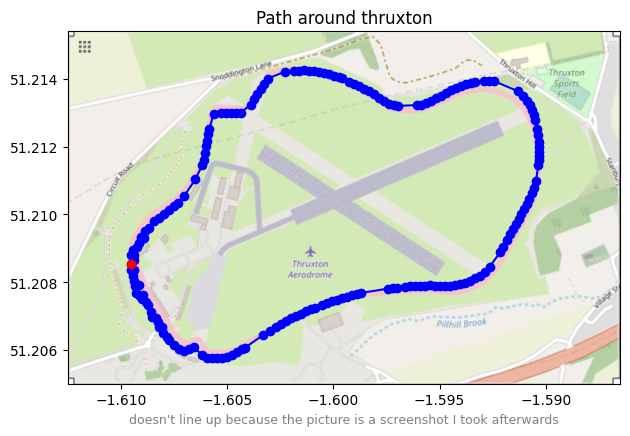

In [81]:
# Load coordinate box around Thruxton
with open("coords.json", "r") as file:
    coords = json.load(file)

# Load path of rider around Thruxton
path = pd.read_csv("path.csv", index_col=False)

bg = Image.open('img/thrux_bg.png')

fig,ax = plt.subplots()
ax.imshow(bg, extent=(coords['W'],coords['E'],coords['S'],coords['N'],)) # type: ignore
ax.plot(path.lon, path.lat, marker='o', linestyle='-', color='blue')
ax.plot(path.iloc[0].lon, path.iloc[0].lat, marker='o', color='red')
ax.set_aspect(aspect(coords['S']))
ax.set_title("Path around thruxton")
ax.set_xlabel("doesn't line up because the picture is a screenshot I took afterwards", fontsize=9, color='gray')

plt.tight_layout()
plt.show()

## Fixing the bounding box

A limitation of the free version of Bing maps's elevation API is that it returns elevations only for rectangular grid of n x m (n and m both integer) points with a size defined by an angle of latitude.
Need to correct the approximate bounding box from `coords.json` so that it's divisible evenly into 75m squares.

Note: bounding boxes get converted to WSGI84 coordinates which is a list of edges in this order: [S, W, E, N]

In [82]:
ANGLE = 0.000_675  # Approx 75m latitude

def resize_bbox(coords, angle=ANGLE):
    """Create nxm rectange, divides evenly into squares with lat=angle.

    Output box always starts in top left corner and expands in multiples of
    `angle` until it reaches bottom right corner and does not exceed that.

    Args:
        coords (dict): Coordinates, keys N, S, E, W
        angle (float): The angle of latitude to break into, default 0.000675
    Returns:
        bbox (list[float]): WSGI84 coordinates, [South, West, East, North]
        N_lat (int): number of rows
        N_lon (int): number of cols
    """

    delta_lat = abs(coords["N"] - coords["S"])
    delta_lon = abs(coords["E"] - coords["W"])

    # meters / degree lon decreases with latitude
    h_angle = aspect(coords["N"] - delta_lat / 2) * angle

    N_lat = floor(delta_lat / angle)
    N_lon = floor(delta_lon / h_angle)

    # Top Left corner
    tl = (coords["N"], coords["W"])
    # Bottom Right corner
    br = (tl[0] - N_lat * angle, tl[1] + N_lon * h_angle)
    # WSGI84 bounding box
    # south latitude, west longitude, north latitude, east longitude
    bbox = [br[0], tl[1], tl[0], br[1]]
    return bbox, N_lat, N_lon


resize = resize_bbox(coords=coords, angle=ANGLE)
print(f"bounding box: {resize[0]}\nNumber of rows,columns: {resize[1]},{resize[2]}")

bounding box: [51.205275, -1.6125, 51.2154, -1.5866406169136296]
Number of rows,columns: 15,24


## Get some elevations

Originally I used the bing maps API but the data is downloaded into `path.csv` now so that's unnecessary. Using the API requires a key (https://learn.microsoft.com/en-us/bingmaps/rest-services/elevations/get-elevations), If you get a key and put it in a file called `.bing_key` in the same folder as this notebook then you can use the `get_elevations()` function.

In [83]:
def get_elevations(key, bbox, rows, cols):
    """Calls the Bing Maps API -> list of coordinates of grid inside bbox.

    Args:
        key (str): Bing Maps API key
        bbox (list[float]): WSGI84 bounding box [S W N E]
        rows (int): Number of latitude boxes
        cols (int): Number of longitude boxes

    Raises:
        ValueError: If rows*cols is greater than max allowed by Bing API (1024)
        Exception: Nonstandard response, e.g. HTTP/400

    Returns:
        list[int]: Heights per coordinate as a flattened array using C style (row-major)
    """
    if rows * cols > 1024:
        raise ValueError("Number of points cannot be larger than 1024")
    URL = f"http://dev.virtualearth.net/REST/v1/Elevation/Bounds?bounds={','.join([str(i) for i in bbox])}&rows={rows}&cols={cols}&key={key}"

    req = requests.get(URL)
    res = req.json()
    if res["statusCode"] != 200:
        raise Exception(f"error for {URL}     Bad request: {res['statusDescription']}")

    return res["resourceSets"][0]["resources"][0]["elevations"]

`elevation_meters` contains a flattened (1d) list of all the elevations.

In [84]:
def elevations(fpath: str | None = None):
    if not fpath:
        # Bing maps API key
        try:
            with open(".bing_key", "r") as file:
                BING_KEY = file.read().strip()
        except FileNotFoundError as e:
            raise FileNotFoundError(
                "Make a file in this folder called '.bing_key' which "
                "contains a Bing maps API key, from "
                "https://learn.microsoft.com/en-us/bingmaps/getting-started/bing-maps-dev-center-help/getting-a-bing-maps-key"
            ) from e

        res = get_elevations(BING_KEY, *resize)
        df = pd.DataFrame(dict(elevation=res))
        df.to_csv("elevation.csv", index=False)
        return res
    else:
        df = pd.read_csv(fpath, index_col=False)
        return df.elevation.astype(int).to_list()


# Change this to True to use the Bing API to get a new list of elevations
RESET_ELEVATIONS = False
if RESET_ELEVATIONS:
    elevation_meters = elevations('elevation.csv')
else:
    elevation_meters = elevations()

print(np.asarray(elevation_meters).reshape(resize[1:]).T)


[[ 90  90  91  91  92  94  96  98 101 104 106 109 111 111 110]
 [ 89  88  89  90  93  95  96  98 101 103 104 108 109 109 107]
 [ 92  93  92  92  94  96  97  98 100 101 102 106 107 107 106]
 [ 93  95  94  95  95  95  96  97  98 101 102 105 106 105 104]
 [ 94  95  95  96  94  94  95  96  97 101 103 103 104 103 102]
 [ 95  95  94  95  94  93  94  95  97 100 102 101 101 100  99]
 [ 94  93  94  93  92  93  94  94  95  97  99 100 100  98  97]
 [ 92  91  92  91  90  92  94  95  95  95  97  99  98  96  95]
 [ 88  88  89  89  89  91  93  95  97  99  97  99  98  95  94]
 [ 85  84  85  87  87  90  92  94  96  98  97  97  96  94  93]
 [ 83  81  83  85  85  88  91  92  95  95  96  95  94  94  93]
 [ 83  81  82  82  83  86  88  91  93  94  96  95  95  96  97]
 [ 84  81  82  81  82  85  88  91  93  93  95  95  95  94  93]
 [ 85  82  82  80  81  84  88  92  93  93  94  94  94  92  89]
 [ 86  82  81  81  82  85  88  91  92  92  94  93  92  89  86]
 [ 86  82  79  80  82  85  88  90  92  92  94  94  93  

## Plot this data


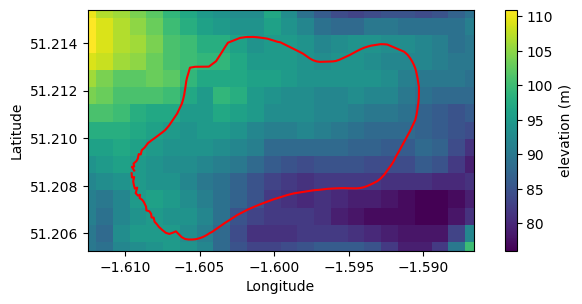

In [85]:
def get_grid(bbox, rows, cols):
    """Numpy x and y arrays from a bbox split into rows & cols."""
    y = np.linspace(bbox[0], bbox[2], rows)
    x = np.linspace(bbox[1], bbox[3], cols)
    return x, y


def plot_elevation(ax, bbox, rows, cols, data, alpha=1.0):
    """Formatted plot of elevation data.

    Args:
        ax (plt.Axes): axis plot on
        bbox (list[float]): WSGI84 bounding box [S W N E]
        rows (int): number of rows
        cols (int): number of cols
        data (list[int]): height data
        alpha (float, optional): Transparency of height colours. Defaults to 1.0.
    """
    x, y = get_grid(bbox, rows, cols)

    XX, YY = np.meshgrid(x, y)
    ZZ = np.reshape(data, (rows, cols))

    im = ax.pcolormesh(XX, YY, ZZ, alpha=alpha)
    ax.set_aspect(aspect(y[rows // 2]))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim((x[0], x[-1]))
    ax.set_ylim(*(y[0], y[-1]))
    return im


bbox = resize[0]
# Aspect for figure size
aspect_ratio = abs((bbox[2] - bbox[0]) / (bbox[3] - bbox[1]))
fig, ax = plt.subplots(1, figsize=(8, 8 * aspect_ratio))

im = plot_elevation(ax, *resize, elevation_meters)
plt.colorbar(im, label="elevation (m)")
grid = get_grid(*resize)



ax.plot(path.lon, path.lat, color="r")
plt.show()

## Create a rider doing laps of course

- Repeat the single lap from before 6 times to get 6 laps
- Add some small random variation to each point to simulate a more realistic ride

In [86]:
dt = 2  # seconds
path_np = np.stack([path.lon, path.lat], axis=0)

# 6 laps of the course
path_np = np.tile(path_np, (1, 6))
# Add random noise to simulate slightly different laps
jitter = path_np + np.random.normal(0, 0.00005, path_np.shape)
# Timestamp of each point along lap
t_jitter = np.arange(jitter.shape[1]) * dt

## Use interpolation to derive the elevation of the rider at each point

Scipy has a function, `interpn`, that can do this in essentially one line. It needs the coordinates (`points`) of a regular grid of data points (`values`) as well as a list of coordinates (`xi`) which all lie within the bounds of the grid for which to interpolate an elevation using the relative distances to the closest grid points.

In [87]:
# Use Scipy's `interpn` N-Dimensional interpolator to approximate the elevation
def interp(points, values, path, method):
    heights = interpn(
        points=(points),  # (x, y) arrays of x and y coordinates
        values=np.c_[values].reshape(
            len(grid[0]), len(grid[1]), order="F"
        ),  # [nx, ny] array of height values
        #   converted to array and reshaped using
        #   Fortran style (column-major)
        xi=path,  # Sample the interpolated grid at the x,y
        #   coordinates of each timestamp of ride
        method=method,  # Use cubic (smooth, slow) interpolation
        #   alternatives are linear (jagged, faster)
        #   and quintic (smoooth, slower)
    )
    return heights


heights = interp(grid, elevation_meters, jitter.T, "cubic")

print(heights)

[95.14158534 95.03070975 95.001834   ... 95.08909855 95.31493833
 95.06724774]


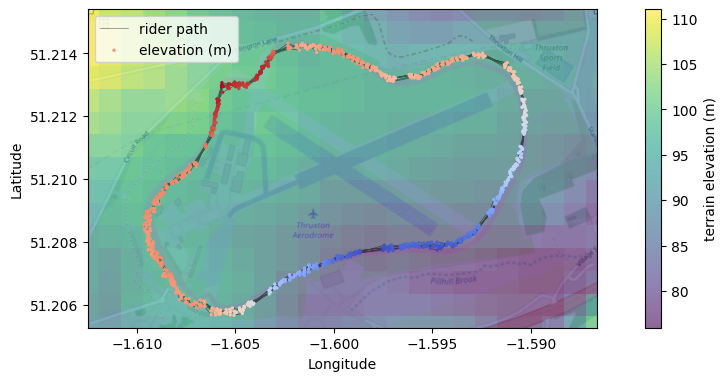

In [88]:
# Plot
fig, ax = plt.subplots(1, figsize=(10, 10 * aspect_ratio))
ax.imshow(bg, extent=(coords['W'],coords['E'],coords['S'],coords['N'],)) # type: ignore
im = plot_elevation(ax, *resize, elevation_meters, alpha=0.6)
XX, YY = np.meshgrid(*grid)
ax.plot(jitter[0], jitter[1], c='k', lw=0.5, alpha=0.5, zorder=2, label='rider path')
ax.scatter(jitter[0], jitter[1], c=heights, s=2, cmap='coolwarm', zorder=3, label='elevation (m)') # type: ignore
plt.colorbar(im, label='terrain elevation (m)')
plt.legend()
plt.tight_layout()
plt.show()

## Visualise the elevation as a timeseries

This solution isn't idential to Ben's problem, but it solves essentially the same issue. I.e. a 2d grid of data points describing elevation (or elevation relative to the start line in Ben's case), and using that to find a specific elecation for a path travelled between that mesh of points.

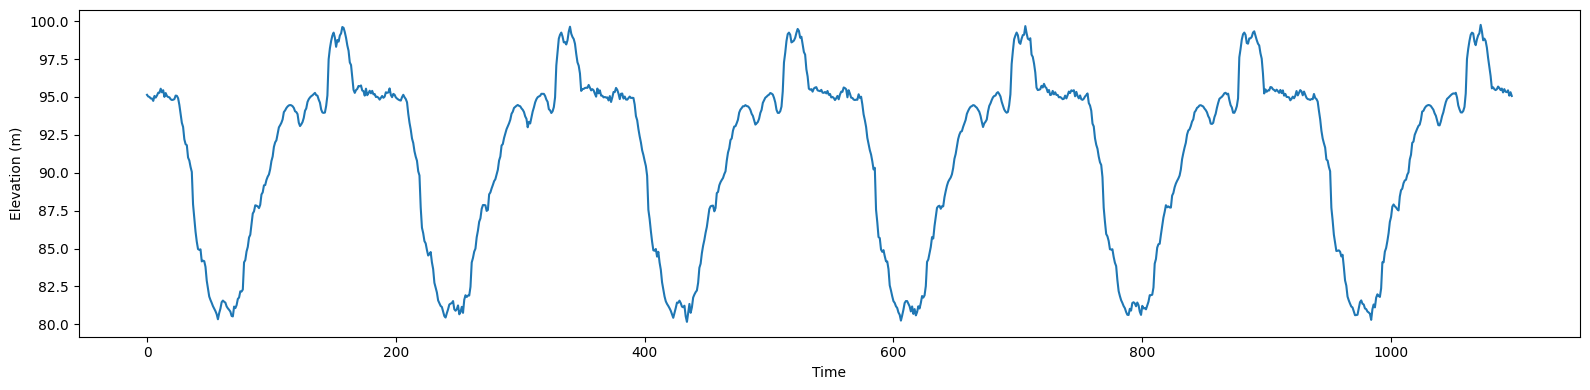

In [89]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(np.arange(*heights.shape), heights)
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Time")
plt.tight_layout()
plt.show()

## Compare interpolation methods


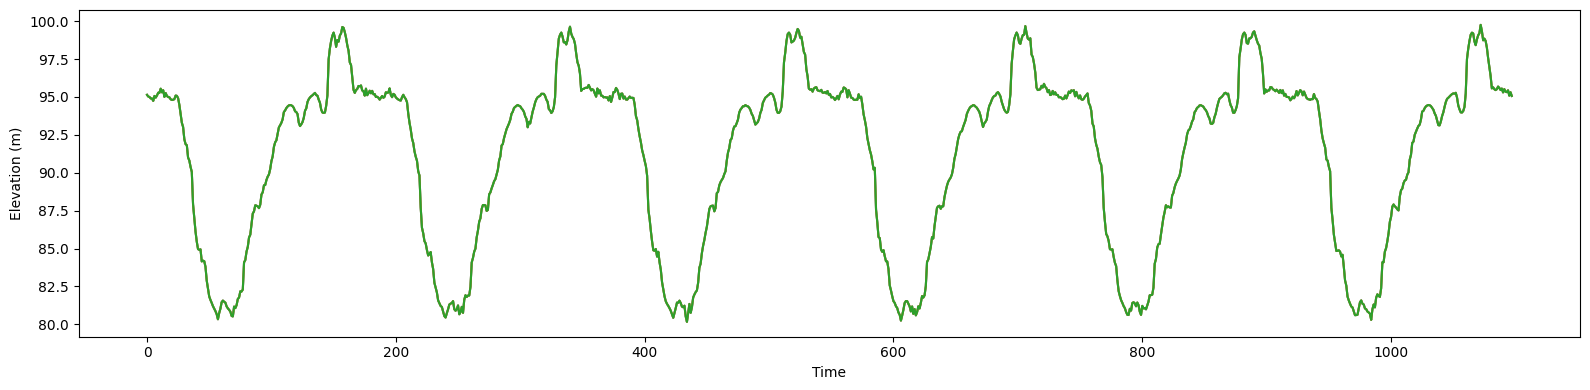

In [90]:
fig, ax = plt.subplots(figsize=(16, 4))

j_cubic = heights
j_linear = interp(grid, elevation_meters, jitter.T, "linear")
j_quintic = interp(grid, elevation_meters, jitter.T, "quintic")

ax.plot(np.arange(*j_cubic.shape), heights, label="cubic")
ax.plot(np.arange(*j_linear.shape), heights, label="linear")
ax.plot(np.arange(*j_quintic.shape), heights, label="quintic")

ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Time")
plt.tight_layout()
plt.show()

In [95]:
linear_time = %timeit -o interp(grid, elevation_meters, jitter.T, "linear")
cubic_time = %timeit -o interp(grid, elevation_meters, jitter.T, "cubic")
quintic_time = %timeit -o interp(grid, elevation_meters, jitter.T, "quintic")

97.8 µs ± 549 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
52.3 ms ± 910 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.2 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


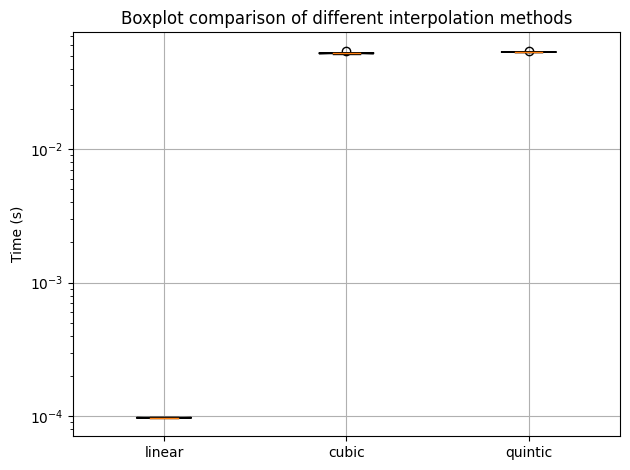

In [118]:
data = [linear_time.timings, cubic_time.timings, quintic_time.timings]
fig, ax = plt.subplots()
ax.boxplot(
    x=data,
    vert=True,
    patch_artist=True,
    notch=True,
    labels=["linear", "cubic", "quintic"],
)
ax.grid(True)
ax.set_yscale('log')
ax.set_ylabel("Time (s)")
ax.set_title("Boxplot comparison of different interpolation methods")
plt.tight_layout()
plt.show()